In [15]:
import pandas as pd
import numpy as np
import os
import cv2 as cv
import matplotlib.pyplot as plt
import time

import tensorflow as tf

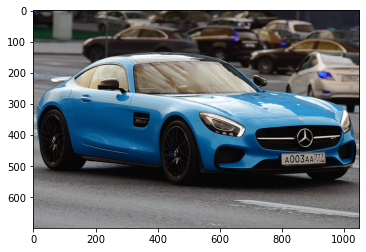

In [16]:
image = cv.imread('car_photo.jpg')
plt.imshow(image)

In [17]:
# activation of selective search
ss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

# set up
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()

# making bboxes
rects = ss.process()
print('Total Number of Region Proposals: {}'.format(len(rects)))

Total Number of Region Proposals: 6168


In [6]:
# create a copy of original image to combinate it with bboxes
img_out = image.copy()

# set the number of boxes we want to draw
num_show_rects = 250

while True:
    # itereate over all the region proposals
    for i in range(len(rects)):
    # draw rectangle for region on the image
      if (i < num_show_rects):
        x, y, w, h = rects[i]
        cv.rectangle(img_out, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA)

    # show output
    cv.imshow('output',img_out)

    # waits for user to press any key 
    # (this is necessary to avoid Python kernel form crashing) 
    key = cv.waitKey(0) 
    if (key == ord('q')):
        break
  
# closing all open windows 
cv.destroyAllWindows() 

In [18]:
model_detector = tf.keras.models.load_model('micro_detector.hdf5')

In [19]:
check_list = []

# slice images for each bbox
for i in range(len(rects)):
  x, y, w, h = rects[i]
  crop_img = image[y:y+h, x:x+w]
  
  #resize to input model size
  crop_img = cv.resize(crop_img, (320, 130))

  check_list.append(crop_img)

# and finally make an np.array
check_list = np.array(check_list)
check_list.shape

(6168, 130, 320, 3)

In [20]:
# use the model to determine the probability of finding a license plate in each of the bboxes
# so far the method takes a long time
start_time = time.time()

answers = model_detector.predict(check_list)

# the output matrix consists of two columns, 
# the first is the probability that it is not a license plate
# the second is the probability that it is a license plate

print("--- %s seconds ---" % (time.time() - start_time))
answers

--- 9.231180906295776 seconds ---


array([[9.8987705e-01, 1.0123013e-02],
       [9.9969029e-01, 3.0973167e-04],
       [9.9940872e-01, 5.9126073e-04],
       ...,
       [9.9019766e-01, 9.8023294e-03],
       [9.9676019e-01, 3.2398847e-03],
       [9.9503481e-01, 4.9652602e-03]], dtype=float32)

In [21]:
max_percentage = answers[:,1].max()
if max_percentage > 0.95:
  index_of_right_bbox = answers[:,1].argmax()

In [22]:
index_of_right_bbox

1846

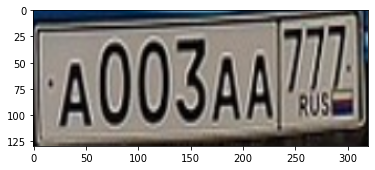

In [23]:
# we can show our license plate
plt.imshow(check_list[index_of_right_bbox])

In [19]:
# create a copy of original image to combinate it with bboxes
img_out = image.copy()

while True:
    x, y, w, h = rects[index_of_right_bbox]
    cv.rectangle(img_out, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA)

    # show output
    cv.imshow('output',img_out)

    # waits for user to press any key 
    # (this is necessary to avoid Python kernel form crashing) 
    key = cv.waitKey(0) 
    if (key == ord('q')):
        break
  
# closing all open windows 
cv.destroyAllWindows() 

In [25]:
# load the model needed to classify symbols
model_symbols = tf.keras.models.load_model('syms_recognitor.hdf5')
print(model_symbols.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 40, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 40, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 20, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 20, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 10, 64)        0

In [26]:
max_image = check_list[index_of_right_bbox].copy()

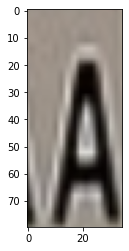

In [27]:
# a method for detecting each character has not yet been made
# so I cut the picture by hand

x0 = max_image[30:110, 15:60]
x1 = max_image[10:110, 55:95]
x2 = max_image[10:110, 90:135]
x3 = max_image[10:110, 130:170] 
x4 = max_image[25:105, 165:200]
x5 = max_image[25:105, 195:230]

plt.imshow(x5)

In [35]:
# bring to the form of model input data
syms = [x0,x1,x2,x3,x4,x5]

number = []
for sym in syms: 
  symbol = cv.resize(sym, (40, 50))
  number.append(symbol)

number = np.array(number)
number.shape

(6, 50, 40, 3)

In [37]:
# use model
result = model_symbols.predict(number)

In [38]:
# output
for i, sym in enumerate(result):
  # at the places of letters, we choose the maximum probability only among letters
  if i in [0,4,5]:
    sym = sym[10:]
    print(sym.argmax()+10)
    
  # at the places of numbers, we choose the maximum probability only among numbers
  if i in [1,2,3]:
    sym = sym[:9]
    print(sym.argmax())

10
0
0
3
10
10


In [39]:
# let's make a dictionary, for a nice output
syms_dict = dict([(0, ['0','O']), #because the model cannot distinguish zero from 'O'
                  (1, '1'),
                  (2, '2'),
                  (3, '3'),
                  (4, '4'),
                  (5, '5'),
                  (6, '6'),
                  (7, '7'),
                  (8, '8'),
                  (9, '9'),
                  (10, 'A'),
                  (11, 'B'),
                  (12, 'C'),
                  (13, 'E'),
                  (14, 'H'),
                  (15, 'K'),
                  (16, 'M'),
                  (17, '1'),
                  (18, 'P'),
                  (19, 'T'),
                  (20, 'X'),
                  (21, 'Y')
                  ])

In [40]:
# and upgrade algorithm a little bit

plate_str = ''

for i, sym in enumerate(result):
  # at the places of letters, we choose the maximum probability only among letters
  if i in [0,4,5]:
    sym = sym[10:]
    res = sym.argmax()+10

    # to account for the difference between zero and 'O'
    if res == 0:
      plate_str += syms_dict[res][1]
    else:
      plate_str += syms_dict[res]

  # at the places of numbers, we choose the maximum probability only among numbers
  if i in [1,2,3]:
    sym = sym[:9]
    res = sym.argmax()

    # to account for the difference between zero and 'O'
    if res == 0:
      plate_str += syms_dict[res][0]
    else:
      plate_str += syms_dict[res]

print(plate_str)

A003AA
